In [1]:


import os

base_dir =  r"C:\Users\Ahmed Hatem\Desktop\Graduation Project\diabetes tongue dataset"  # <- your new dataset path
train_dir = os.path.join(base_dir, 'output_train')
val_dir   = os.path.join(base_dir, 'output_valid')

print("Train folders:", os.listdir(train_dir))
print("Validation folders:", os.listdir(val_dir))



Train folders: ['diabetes', 'non_diabetes']
Validation folders: ['diabetes', 'non_diabetes']


In [6]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_SIZE = 224  # PyTorch expects int, not tuple
BATCH_SIZE = 32

train_dir = r"C:\Users\Ahmed Hatem\Desktop\Graduation Project\diabetes tongue dataset\output_train"
val_dir   = r"C:\Users\Ahmed Hatem\Desktop\Graduation Project\diabetes tongue dataset\output_valid"

# Keep your augmentation exactly the same
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),  # approximate zoom_range
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data   = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

print("Classes:", train_data.classes)


Classes: ['diabetes', 'non_diabetes']


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# -----------------------------
# 1️⃣ Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 2️⃣ Load pretrained MobileNetV2
# -----------------------------
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze base model
for param in base_model.features.parameters():
    param.requires_grad = False

# -----------------------------
# 3️⃣ Build classifier head
# -----------------------------
class DiabetesClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)       # GlobalAveragePooling2D
        self.bn1 = nn.BatchNorm1d(base_model.last_channel)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(base_model.last_channel, 128)  # Dense(128) with L2 handled in optimizer
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(128, 1)           # binary output

    def forward(self, x):
        x = self.base(x)
        x = self.pool(x).view(x.size(0), -1)      # flatten
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.output(x)
        x = torch.sigmoid(x)                      # binary classification
        return x

# -----------------------------
# 4️⃣ Instantiate model
# -----------------------------
model = DiabetesClassifier(base_model).to(device)

# -----------------------------
# 5️⃣ Optimizer + Loss
# -----------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization
criterion = nn.BCELoss()  # binary cross-entropy

# -----------------------------
# 6️⃣ Summary
# -----------------------------
from torchsummary import summary
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [10]:
# Print the mapping from class names to numeric labels
print("Train classes:", train_data.class_to_idx)
print("Validation classes:", val_data.class_to_idx)


Train classes: {'diabetes': 0, 'non_diabetes': 1}
Validation classes: {'diabetes': 0, 'non_diabetes': 1}


In [11]:
import numpy as np

# Get all labels
train_labels = [label for _, label in train_data.samples]
val_labels = [label for _, label in val_data.samples]

# Count number of images per class
train_counts = np.bincount(train_labels)
val_counts = np.bincount(val_labels)

print("Train counts:", train_counts)
print("Validation counts:", val_counts)


Train counts: [497 498]
Validation counts: [46 48]


In [12]:
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # ---------------------
    # Training
    # ---------------------
    model.train()
    running_train_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * imgs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---------------------
    # Validation
    # ---------------------
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().to(device)
            outputs = model(imgs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * imgs.size(0)

            all_preds.extend((outputs > 0.5).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")


Epoch 1/10 | Train Loss: 0.5997 | Val Loss: 0.5215 | Val Acc: 0.7021
Epoch 2/10 | Train Loss: 0.4130 | Val Loss: 0.4010 | Val Acc: 0.8617
Epoch 3/10 | Train Loss: 0.3586 | Val Loss: 0.3648 | Val Acc: 0.8723
Epoch 4/10 | Train Loss: 0.3116 | Val Loss: 0.3343 | Val Acc: 0.8830
Epoch 5/10 | Train Loss: 0.3061 | Val Loss: 0.3211 | Val Acc: 0.8830
Epoch 6/10 | Train Loss: 0.2887 | Val Loss: 0.3105 | Val Acc: 0.8830
Epoch 7/10 | Train Loss: 0.2848 | Val Loss: 0.2942 | Val Acc: 0.8830
Epoch 8/10 | Train Loss: 0.2622 | Val Loss: 0.2831 | Val Acc: 0.8936
Epoch 9/10 | Train Loss: 0.2555 | Val Loss: 0.2693 | Val Acc: 0.8936
Epoch 10/10 | Train Loss: 0.2477 | Val Loss: 0.2559 | Val Acc: 0.9149


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1️⃣ Unfreeze last layers for fine-tuning
# -----------------------------
# Let's unfreeze the last 3 blocks of MobileNetV2
for i, param in enumerate(model.base.parameters()):
    # MobileNetV2 has 18 layers (approx blocks in features)
    # Adjust depending on PyTorch version if necessary
    if i >= len(list(model.base.parameters())) - 30:  # unfreeze last 30 params (~last 3 blocks)
        param.requires_grad = True

# -----------------------------
# 2️⃣ Optimizer for fine-tuning
# -----------------------------
# Use smaller learning rate for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
criterion = nn.BCELoss()

# -----------------------------
# 3️⃣ EarlyStopping & ModelCheckpoint setup
# -----------------------------
best_val_loss = float("inf")
patience = 5
patience_counter = 0
num_epochs = 20  # you can adjust

def save_checkpoint(model, path="best_model_finetuned.pt"):
    torch.save(model.state_dict(), path)

# -----------------------------
# 4️⃣ Fine-tuning loop
# -----------------------------
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * imgs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.float().to(device)
            outputs = model(imgs).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * imgs.size(0)

            all_preds.extend((outputs > 0.5).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f}")

    # ---- ReduceLROnPlateau ----
    # Optional: you can add scheduler.step(epoch_val_loss) if using a scheduler
    # scheduler.step(epoch_val_loss)

    # ---- EarlyStopping & ModelCheckpoint ----
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        save_checkpoint(model, "best_model_finetuned.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# -----------------------------
# 5️⃣ Load best fine-tuned model
# -----------------------------
model.load_state_dict(torch.load("best_model_finetuned.pt"))
model.eval()


Epoch 1/20 | Train Loss: 0.2427 | Val Loss: 0.2462 | Val Acc: 0.9043
Epoch 2/20 | Train Loss: 0.2048 | Val Loss: 0.2247 | Val Acc: 0.9149
Epoch 3/20 | Train Loss: 0.2023 | Val Loss: 0.2207 | Val Acc: 0.9149
Epoch 4/20 | Train Loss: 0.2050 | Val Loss: 0.2246 | Val Acc: 0.9255
Epoch 5/20 | Train Loss: 0.1862 | Val Loss: 0.1965 | Val Acc: 0.9362
Epoch 6/20 | Train Loss: 0.1928 | Val Loss: 0.1979 | Val Acc: 0.9255
Epoch 7/20 | Train Loss: 0.1646 | Val Loss: 0.1880 | Val Acc: 0.9362
Epoch 8/20 | Train Loss: 0.1606 | Val Loss: 0.1837 | Val Acc: 0.9362
Epoch 9/20 | Train Loss: 0.1805 | Val Loss: 0.1869 | Val Acc: 0.9362
Epoch 10/20 | Train Loss: 0.1666 | Val Loss: 0.1810 | Val Acc: 0.9255
Epoch 11/20 | Train Loss: 0.1524 | Val Loss: 0.1742 | Val Acc: 0.9362
Epoch 12/20 | Train Loss: 0.1633 | Val Loss: 0.1692 | Val Acc: 0.9149
Epoch 13/20 | Train Loss: 0.1537 | Val Loss: 0.1741 | Val Acc: 0.9362
Epoch 14/20 | Train Loss: 0.1634 | Val Loss: 0.1693 | Val Acc: 0.9255
Epoch 15/20 | Train Loss: 0.1

DiabetesClassifier(
  (base): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

In [22]:
import torch
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 1️⃣ Load the best saved model
# -----------------------------
# Make sure your model class is defined exactly as before
model.load_state_dict(torch.load("best_model_finetuned.pt", map_location=device))
model.eval()  # set to evaluation mode
model.to(device)

# -----------------------------
# 2️⃣ Define preprocessing (same as training)
# -----------------------------
IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# -----------------------------
# 3️⃣ Load a new image
# -----------------------------
img_path = r"C:\Users\Ahmed Hatem\Desktop\Graduation Project\diabetes tongue dataset\r_nd_(56).jpg"
img = Image.open(img_path).convert("RGB")  # ensure 3 channels
img_tensor = preprocess(img).unsqueeze(0).to(device)  # add batch dimension

# -----------------------------
# 4️⃣ Predict
# -----------------------------
with torch.no_grad():
    output = model(img_tensor).item()  # sigmoid output
    predicted_label = 1 if output > 0.5 else 0

# -----------------------------
# 5️⃣ Map numeric label back to class name
# -----------------------------
class_mapping = train_data.class_to_idx  # {'diabetes':0, 'non_diabetes':1}
idx_to_class = {v:k for k,v in class_mapping.items()}
predicted_class = idx_to_class[predicted_label]

print(f"Predicted probability of non diabetes: {output:.4f}")
print(f"Predicted class: {predicted_class}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Ahmed Hatem\\Desktop\\Graduation Project\\diabetes tongue dataset\\r_nd_(56).jpg'

Found 100 images belonging to 2 classes.
3/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
CLASSIFICATION REPORT

              precision    recall  f1-score   support

    diabetes     0.9756    0.8000    0.8791        50
non_diabetes     0.8305    0.9800    0.8991        50

    accuracy                         0.8900       100
   macro avg     0.9031    0.8900    0.8891       100
weighted avg     0.9031    0.8900    0.8891       100



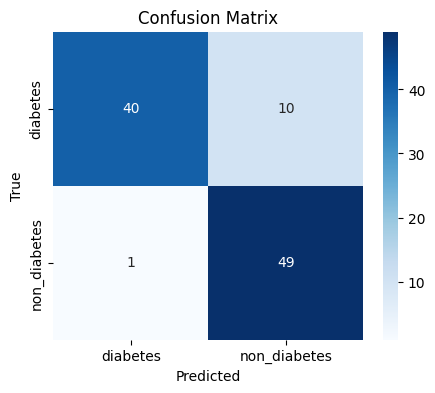

ROC AUC: 0.9588


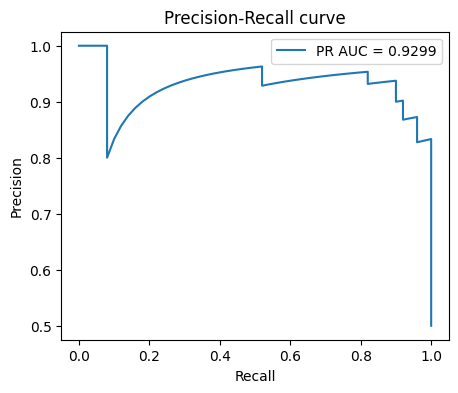

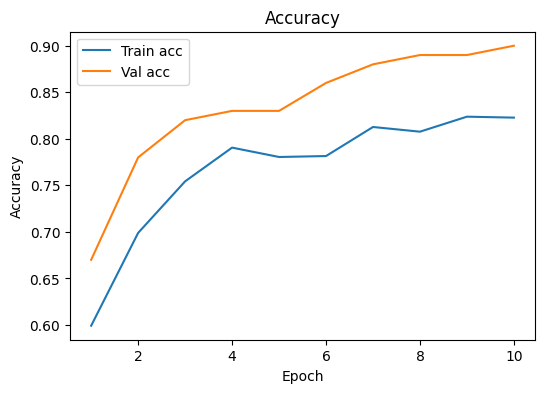

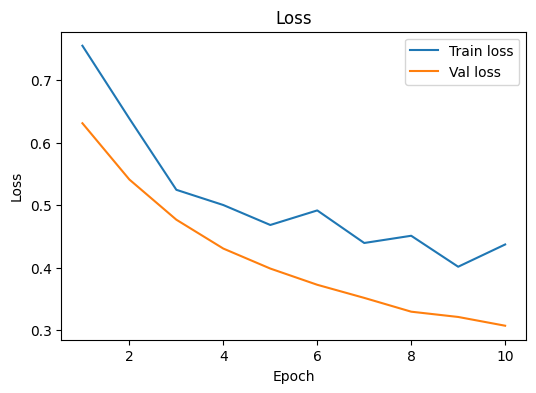

In [ ]:
# ---------- 1) recreate val generator with shuffle=False so labels align ----------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

base_dir = "/content/drive/MyDrive/diabetes_dataset/output_valid"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

val_datagen = ImageDataGenerator(rescale=1./255)

# recreate validation generator with shuffle=False so ordering is deterministic
val_data_fixed = val_datagen.flow_from_directory(
    base_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',    # binary because model uses sigmoid
    shuffle=False,
    seed=SEED
)

# ---------- 2) load best model if not already loaded ----------
from tensorflow.keras.models import load_model
# change path if your model filepath is different
best_model = load_model("/content/best_model.keras")

# ---------- 3) predict on validation set (full pass) ----------
steps = len(val_data_fixed)  # number of batches
y_true = val_data_fixed.classes  # ground truth labels in order
probs = best_model.predict(val_data_fixed, steps=steps, verbose=1)

# handle both shapes: (N,1) sigmoid or (N,2) softmax
if probs.ndim == 2 and probs.shape[1] == 1:
    y_prob_pos = probs.ravel()
    y_pred = (y_prob_pos > 0.5).astype(int)
elif probs.ndim == 2 and probs.shape[1] == 2:
    y_prob_pos = probs[:,1]
    y_pred = np.argmax(probs, axis=1)
else:
    y_prob_pos = probs.ravel()
    y_pred = (y_prob_pos > 0.5).astype(int)

# ---------- 4) classification report + confusion matrix ----------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

print("CLASSIFICATION REPORT\n")
print(classification_report(y_true, y_pred, target_names=["diabetes","non_diabetes"], digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["diabetes","non_diabetes"],
            yticklabels=["diabetes","non_diabetes"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ---------- 5) ROC AUC (for the positive class) ----------
try:
    roc_auc = roc_auc_score(y_true, y_prob_pos)
    print(f"ROC AUC: {roc_auc:.4f}")
except Exception as e:
    print("ROC AUC could not be computed:", e)

# ---------- 6) Precision-Recall curve and PR AUC ----------
precision, recall, _ = precision_recall_curve(y_true, y_prob_pos)
pr_auc = auc(recall, precision)
plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.show()

# ---------- 7) Plot training/validation accuracy & loss if 'history' exists ----------
if 'history' in globals():
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])
    epochs = range(1, len(acc)+1)
    if len(acc) > 0:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, acc, label="Train acc")
        plt.plot(epochs, val_acc, label="Val acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Accuracy")
        plt.show()
    if len(loss) > 0:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, loss, label="Train loss")
        plt.plot(epochs, val_loss, label="Val loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss")
        plt.show()
else:
    print("No 'history' object found in environment — skip plotting training curves.")
